In [2]:
import numpy as np, sympy as smp
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.integrate import quad, dblquad, tplquad

plt.style.use(['science','notebook','grid', 'dark_background'])

# Potential and Electric Field of a Dipole:

In [62]:
e, eps0 = 1.602e-19, 8.854e-12
delta = 1.5e-12

In [63]:
xv = np.linspace(-5e-11, 5e-11, 1000)
yv = xv.copy()
xv, yv = np.meshgrid(xv, yv)

V = 1 * e * delta / (4 * np.pi * eps0) * xv / np.hypot(xv, yv) ** 3

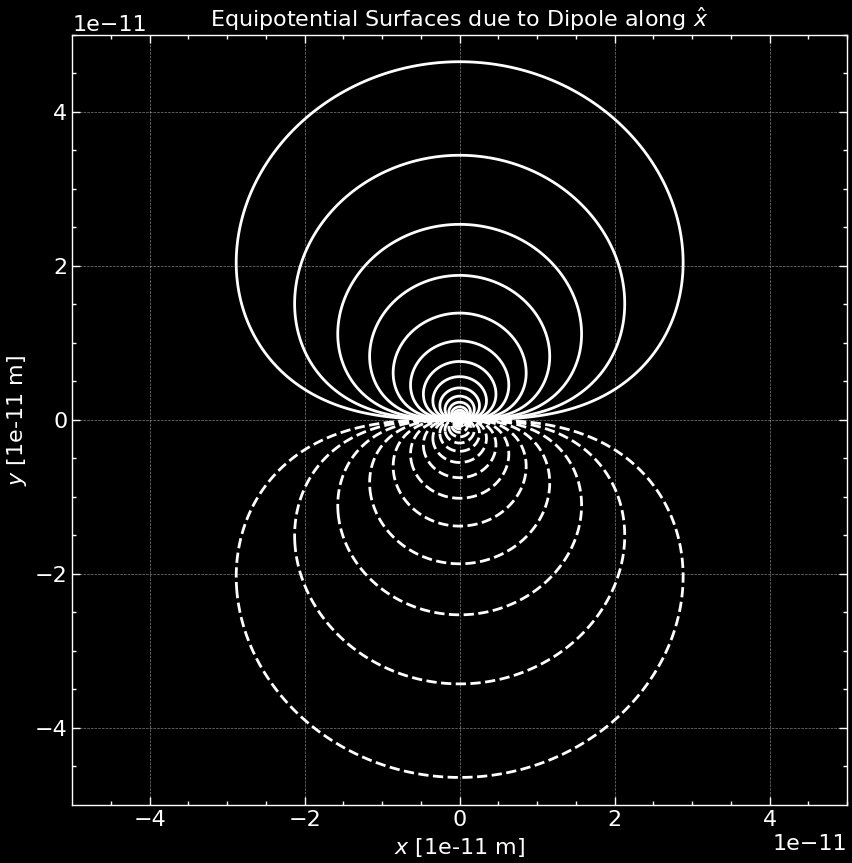

In [64]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)

levels = np.array([10 ** pw for pw in np.linspace(0, 5, 20)])
levels = sorted(list(-levels) + list(levels))

ax.contour(yv, xv, V, levels = levels, colors = 'w', linewidths = 2)
plt.xlabel(r'$x$ [1e-11 m]')
plt.ylabel(r'$y$ [1e-11 m]')
plt.title(r'Equipotential Surfaces due to Dipole along $\hat{x}$')
plt.show()

Field Lines:

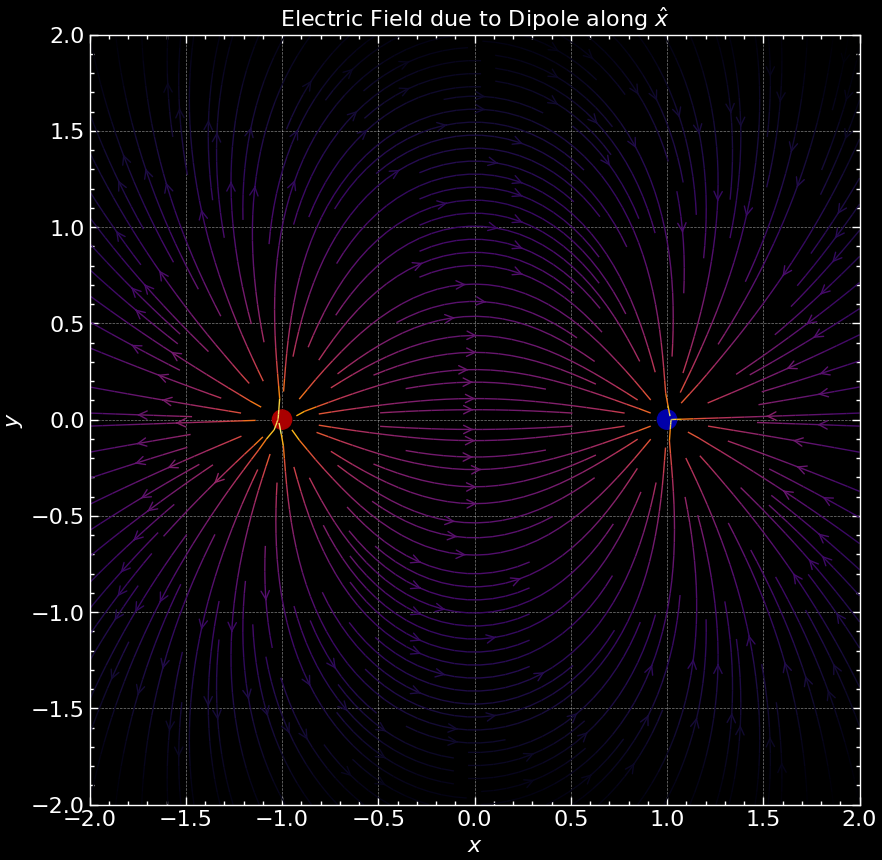

In [65]:
def E(q, r0, x, y):
    den = np.hypot(x - r0[0], y - r0[1]) ** 3
    return q * (x - r0[0]) / den, q * (y - r0[1]) / den

nx, ny = 64, 64
x = np.linspace(-2, 2, nx)
y = np.linspace(-2, 2, ny)
X, Y = np.meshgrid(x, y)

nq = 2
charges = []
for i in range(nq):
    q = i % 2 * 2 - 1
    charges.append((q, (np.cos(2 * np.pi * i / nq), np.sin(2 * np.pi * i / nq))))

Ex, Ey = np.zeros((ny, nx)), np.zeros((ny, nx))
for charge in charges:
    ex, ey = E(*charge, x = X, y = Y)
    Ex += ex
    Ey += ey

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)

color = 2 * np.log(np.hypot(Ex, Ey))
ax.streamplot(x, y, Ex, Ey, color = color, linewidth = 1, cmap = plt.cm.inferno,
              density = 2, arrowstyle = '->', arrowsize = 1.5)

charge_colors = {True: '#aa0000', False: '#0000aa'}
for q, pos in charges:
    ax.add_artist(Circle(pos, 0.05, color = charge_colors[q > 0]))

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title(r'Electric Field due to Dipole along $\hat{x}$')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
plt.show()

# Potential due to any configuration:

Suppose two charges $\pm q$ are separated by $\vec \delta$ (which points from $-q$ to $+q$) with their centre at $\vec{\mathscr R}.$ In the limit $\delta \to 0$ and $q\delta=\mathrm{constant}$ the Potential at a point $\vec{\mathscr r}$ is $$V(\vec r)=\frac 1{4\pi \epsilon_0}\frac{\vec p \cdot (\vec r-\vec{\mathscr R})}{\|\vec r-\vec{\mathscr R}\|}$$ where $\vec p=q\vec \delta.$ This is an Electric Dipole with Dipole Moment $\vec p.$ 

Suppose there are many dipoles in some medium packed together. We can then write $d\vec p=\vec P(\vec{\mathscr R})\,d\mathscr T$ as the Total Dipole Moment in that small element $d\mathscr T.$ $\vec P$ is called the Dipole Density and $d\mathscr T$ can correspond to a region of space, either in:
- 1 dimension: $d\mathscr T=\|d\vec{\mathscr R}\|$
- 2 dimensions: $d\mathscr T=\|\vec{\mathscr R_u'}\times \vec{\mathscr R_v'}\|\,dudv$
- 3 dimensions: $d\mathscr T=d\tau$

The Total Potential is then $$V(\vec r)=\frac 1{4\pi \epsilon_0}\int_\xi \frac{\vec P(\vec{\mathscr R})\cdot(\vec r-\vec{\mathscr R})}{\|\vec r-\vec{\mathscr R}\|^3}\,d\mathscr T$$ where $\xi$ is the reigion of space one wishes to integrate over. 

# 1 Dimension:

Consider an object with:
- $\displaystyle \vec{\mathscr R}(t)=R\,\langle 2\cos(4t),2\sin(4t),t\rangle$ as $t \in [-\pi/2,\pi/2]$ where $R$ is a particular reference length and $t$ is a parameter.
- $\displaystyle \vec r=\langle x,y,z \rangle$
- Dipole Density: $\displaystyle \vec P(\vec{\mathscr R})=P_0|z|\,\hat z$
- Region: $\displaystyle d\mathscr T=\|d\vec{\mathscr R}\|=\bigg\|\frac{d\vec{\mathscr R}}{dt}\bigg\|\,dt$

All the following python variables are made to be dimensionless:

In [66]:
t = smp.symbols('t', real = True)
x, y, z = smp.symbols('x y z', real = True)
X, Y, Z = smp.symbols('X Y Z', cls = smp.Function)
Px, Py, Pz = smp.symbols('P_x P_y P_z', cls = smp.Function)

In [67]:
X = X(t)
Y = Y(t)
Z = Z(t)

In [68]:
Px = 0
Py = 0
Pz = smp.Abs(Z)

In [69]:
r = smp.Matrix([x, y, z])
R = smp.Matrix([X, Y, Z])
P = smp.Matrix([Px, Py, Pz])

sep = r - R
sep

Matrix([
[x - X(t)],
[y - Y(t)],
[z - Z(t)]])

In [70]:
integrand = P.dot(sep) / sep.norm() ** 3 * smp.diff(R, t).norm()
integrand = integrand.subs([(X, 2 * smp.cos(4 * t)), (Y, 2 * smp.sin(4 * t)), (Z, t)]).simplify()

integrand

-sqrt(65)*(t - z)*Abs(t)/((t - z)**2 + (x - 2*cos(4*t))**2 + (y - 2*sin(4*t))**2)**(3/2)

In [71]:
integrand_f = smp.lambdify([t, x, y, z], integrand)

def V(x, y, z):
    return quad(integrand_f, -np.pi / 2, np.pi / 2, args = (x, y, z))[0]

In [72]:
x = np.linspace(-1, 1, 30)
y = np.linspace(-1, 1, 30)

xv, yv = np.meshgrid(x, y)
v = np.vectorize(V)(xv, yv, 0)

Text(0, 0.5, '$y/R$')

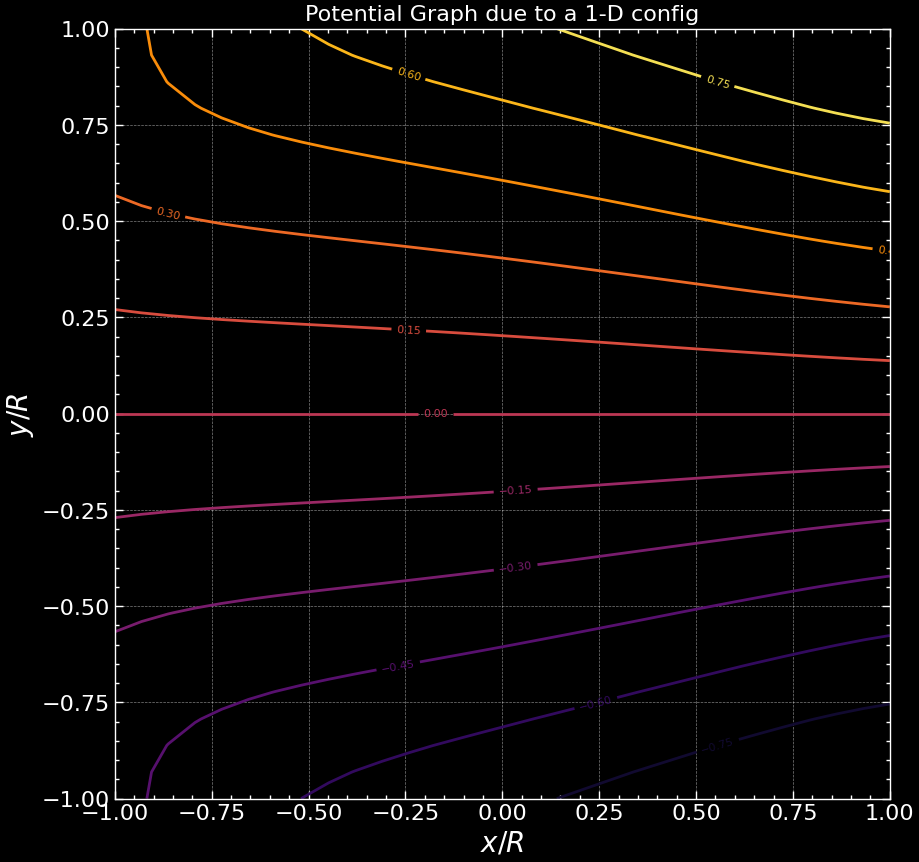

In [73]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
cs = plt.contour(xv, yv, v, levels = 15, cmap = 'inferno')

plt.clabel(cs, fontsize = 8)
plt.title('Potential Graph due to a 1-D config')
plt.xlabel(r'$x/R$', fontsize = 20)
plt.ylabel(r'$y/R$', fontsize = 20)

# 2 Dimensions:

Consider an object with:
- $\displaystyle \vec{\mathscr R}(u, v)=\langle u\cos(v),u\sin(v),u^2\rangle$ as $u \in [0,2]$ and $v \in [0,2\pi]$ where $u$ and $v$ are parameters.
- $\displaystyle \vec r=\langle x,y,z \rangle$
- Dipole Density: $\displaystyle \vec P(\vec{\mathscr R})=P_0e^{-|x^2|}\,\hat z$
- Region: $\displaystyle d\mathscr T=\|\vec{\mathscr R_u'}\times \vec{\mathscr R_v'}\|\,dudv$

All the following python variables are made to be dimensionless:

In [74]:
u, v = smp.symbols('u v', real = True)
x, y, z =smp.symbols('x y z', real = True)
X, Y, Z = smp.symbols('X Y Z', cls = smp.Function)
Px, Py, Pz = smp.symbols('P_x P_y P_z', cls = smp.Function)

In [75]:
X = X(u, v)
Y = Y(u, v)
Z = Z(u, v)

In [76]:
Px = 0
Py = 0
Pz = smp.exp(-X ** 2)

In [77]:
r = smp.Matrix([x, y, z])
R = smp.Matrix([X, Y, Z])
P = smp.Matrix([Px, Py, Pz])

sep = r - R
sep

Matrix([
[x - X(u, v)],
[y - Y(u, v)],
[z - Z(u, v)]])

In [78]:
dT = (smp.diff(R, u).cross(smp.diff(R, v))).norm()
integrand = P.dot(sep)/sep.norm() ** 3 * dT
integrand

(z - Z(u, v))*sqrt(Abs(Derivative(X(u, v), u)*Derivative(Y(u, v), v) - Derivative(X(u, v), v)*Derivative(Y(u, v), u))**2 + Abs(Derivative(X(u, v), u)*Derivative(Z(u, v), v) - Derivative(X(u, v), v)*Derivative(Z(u, v), u))**2 + Abs(Derivative(Y(u, v), u)*Derivative(Z(u, v), v) - Derivative(Y(u, v), v)*Derivative(Z(u, v), u))**2)*exp(-X(u, v)**2)/(Abs(x - X(u, v))**2 + Abs(y - Y(u, v))**2 + Abs(z - Z(u, v))**2)**(3/2)

In [79]:
integrand = integrand.subs([(X, u * smp.cos(v)), (Y, u * smp.sin(v)), (Z, u ** 2)]).simplify()
integrand

(-u**2 + z)*sqrt(4*u**2 + 1)*exp(-u**2*cos(v)**2)*Abs(u)/((u**2 - z)**2 + (-u*sin(v) + y)**2 + (-u*cos(v) + x)**2)**(3/2)

In [80]:
integrand_f = smp.lambdify([u, v, x, y, z], integrand)

def V(x, y, z):
    return dblquad(integrand_f, 0, 2 * np.pi, lambda x: 0, lambda x: 2, args = (x, y, z))[0]

In [81]:
x = np.linspace(-0.5, 0.5, 30)
y = np.linspace(-0.5, 0.5, 30)

xv, yv = np.meshgrid(x, y)
v = np.vectorize(V)(xv, yv, 2)

Text(0, 0.5, '$y/R$')

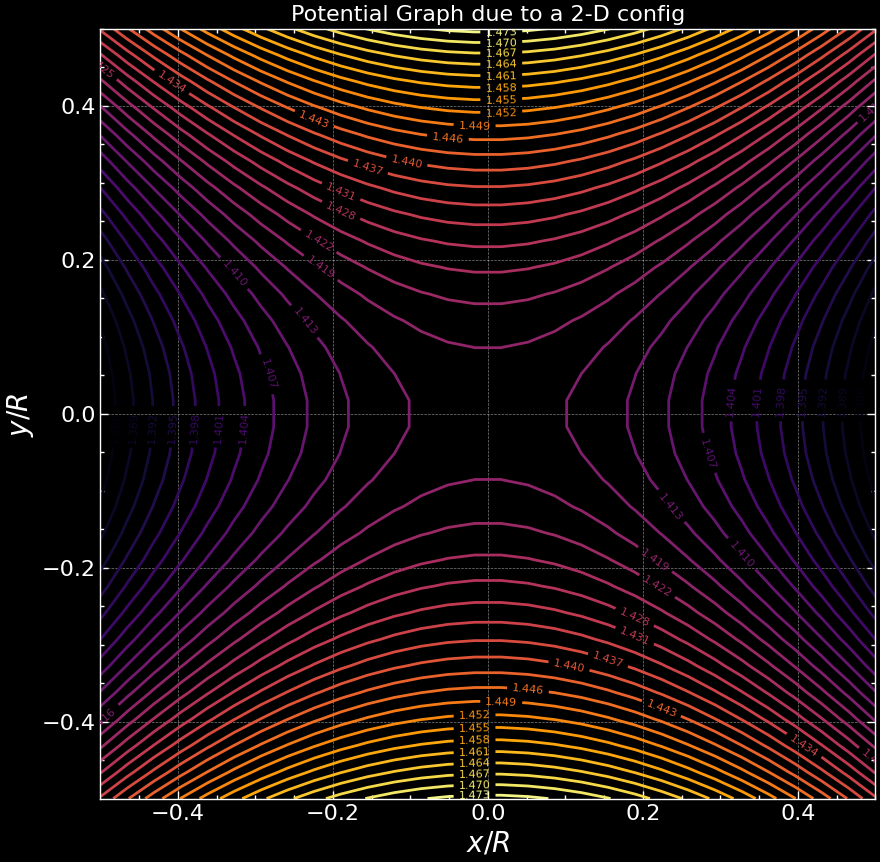

In [82]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
cs = plt.contour(xv, yv, v, levels = 30, cmap = 'inferno')

plt.clabel(cs, fontsize = 8)
plt.title('Potential Graph due to a 2-D config')
plt.xlabel(r'$x/R$', fontsize = 20)
plt.ylabel(r'$y/R$', fontsize = 20)

# 3 Dimensions:

Consider an object with:
- $\displaystyle \vec{\mathscr R}(\rho, \theta, \phi)=\langle \rho\cos(\theta)\sin(\phi),\rho\sin(\theta)\sin(\phi), \rho\cos(\phi)\rangle$ as $\rho \in [0,1],$ $\theta \in [0,\pi]$ and $\phi \in [0,2\pi]$ where $\rho,$ $\theta$ and $\phi$ are parameters.
- $\displaystyle \vec r=\langle x,y,z \rangle$
- Dipole Density: $\displaystyle \vec P(\vec{\mathscr R})=P_0\,\hat z$
- Region: $\displaystyle d\mathscr T=d\tau=\rho^2\sin(\theta)\,d\rho d\theta d\phi$

All the following python variables are made to be dimensionless:

In [3]:
rho, theta, phi = smp.symbols(r'\rho \theta \phi', real = True)
x, y, z = smp.symbols('x y z', real = True)
X, Y, Z = smp.symbols('X Y Z', cls = smp.Function)
Px, Py, Pz = smp.symbols('P_x P_y P_z', cls = smp.Function)

In [4]:
X = X(rho, theta, phi)
Y = Y(rho, theta, phi)
Z = Z(rho, theta, phi)

In [5]:
Px = 0
Py = 0
Pz = 1

In [6]:
r = smp.Matrix([x, y, z])
R = smp.Matrix([X, Y, Z])
P = smp.Matrix([Px, Py, Pz])

sep = r - R
sep

Matrix([
[x - X(\rho, \theta, \phi)],
[y - Y(\rho, \theta, \phi)],
[z - Z(\rho, \theta, \phi)]])

In [7]:
dT = rho ** 2 * smp.sin(theta)
integrand = P.dot(sep)/sep.norm() ** 3 * dT
integrand

\rho**2*(z - Z(\rho, \theta, \phi))*sin(\theta)/(Abs(x - X(\rho, \theta, \phi))**2 + Abs(y - Y(\rho, \theta, \phi))**2 + Abs(z - Z(\rho, \theta, \phi))**2)**(3/2)

In [8]:
integrand = integrand.subs([(X, rho * smp.cos(theta) * smp.sin(phi)), (Y, rho * smp.sin(theta) * smp.sin(phi)), (Z, rho * smp.cos(phi))]).simplify()
integrand

-\rho**2*(\rho*cos(\phi) - z)*sin(\theta)/((\rho*cos(\phi) - z)**2 + (\rho*sin(\phi)*sin(\theta) - y)**2 + (\rho*sin(\phi)*cos(\theta) - x)**2)**(3/2)

In [9]:
integrand_f = smp.lambdify([rho, theta, phi, x, y, z], integrand)

def V(x, y, z):
    return tplquad(integrand_f, 0, 2 * np.pi, lambda x: 0, lambda x: np.pi, lambda x, y: 0, lambda x, y: 1, args = (x, y, z))[0]

In [10]:
x = np.linspace(-0.5, 0.5, 30)
y = np.linspace(-0.5, 0.5, 30)

xv, yv = np.meshgrid(x, y)
v = np.vectorize(V)(xv, yv, 2)

Text(0, 0.5, '$y/R$')

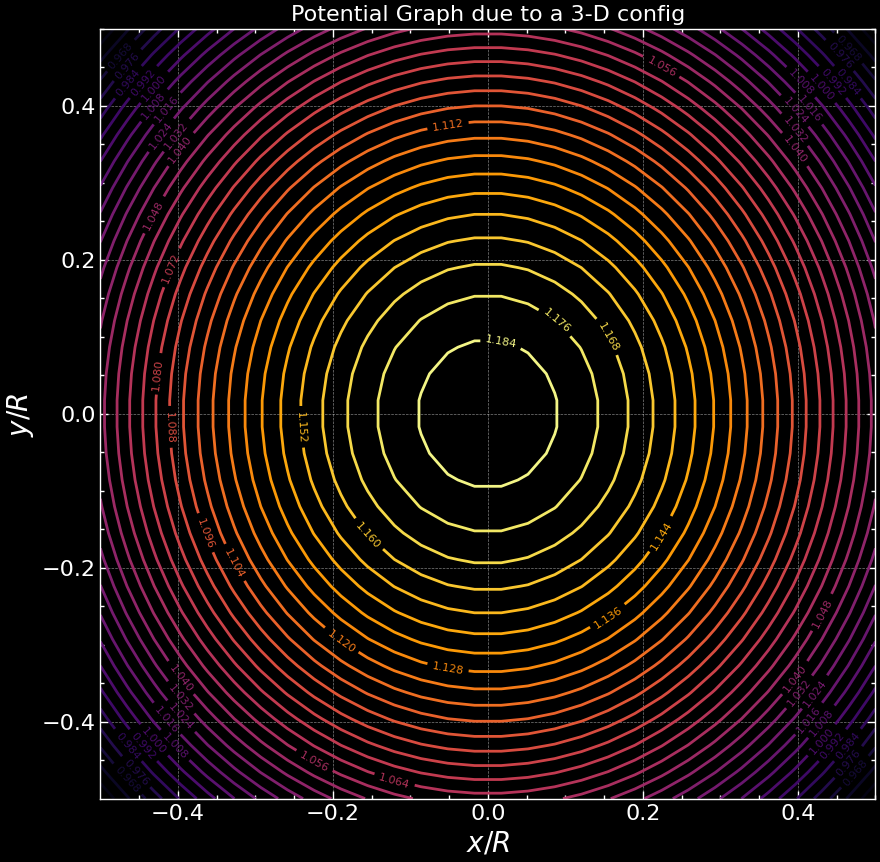

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
cs = plt.contour(xv, yv, v, levels = 30, cmap = 'inferno')

plt.clabel(cs, fontsize = 8)
plt.title('Potential Graph due to a 3-D config')
plt.xlabel(r'$x/R$', fontsize = 20)
plt.ylabel(r'$y/R$', fontsize = 20)